In [ ]:
# from google.colab import files
# import io

# uploaded = files.upload()

Saving mymoviedb.csv to mymoviedb (1).csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [3]:
movies = pd.read_csv("mymoviedb.csv", lineterminator="\n")
# movies = pd.read_csv(io.StringIO(uploaded["mymoviedb.csv"].decode("utf-8")), lineterminator="\n")
movies.drop(movies[movies["Vote_Count"] == 0].index,
            inplace=True)  # usun filmy z przyszlosci
movies.drop(["Overview", "Popularity", "Vote_Count",
            "Poster_Url"], axis=1, inplace=True)

X = movies.drop("Vote_Average", axis=1)
y = movies["Vote_Average"]


In [4]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)
kFold = KFold(n_splits=5)


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


In [6]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


In [7]:
from sklearn.preprocessing import OneHotEncoder

simple_cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Original_Language"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

simple_cat_pipeline.fit_transform(X_train)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
from datetime import datetime


class DateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols = []
        for col_name in X.columns:
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").year))
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").month))
        return np.c_[cols].T


In [9]:
date_pipeline = Pipeline([
    ("select_date", DataFrameSelector(["Release_Date"])),
    ("imputer", MostFrequentImputer()),
    ("date_encoder", DateEncoder()),
])

date_pipeline.fit_transform(X_train)


array([[2015,    1],
       [2005,    9],
       [1992,    4],
       ...,
       [1983,    7],
       [2015,    7],
       [2007,    3]], dtype=int64)

In [10]:
class GenreEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, delimeter=","):
        self.genres = {}
        for col in X.columns:
            self.genres[col] = set()
            for index, row in X.iterrows():
                self.genres[col] |= set(
                    map(lambda x: x.strip(), row[col].split(delimeter)))
        return self

    def transform(self, X, y=None):
        encoded = []
        returned = []
        for col, curr_genres in self.genres.items():
            for genre in curr_genres:
                encoded.append(X[col].str.contains(genre).astype(int))
            returned.append(pd.DataFrame(data=np.c_[encoded].T, columns=self.genres[col]))
        return pd.concat(returned, axis=1)


In [11]:
genre_pipeline = Pipeline([
    ("select_genre", DataFrameSelector(["Genre"])),
    ("imputer", MostFrequentImputer()),
    ("genre_encoder", GenreEncoder()),
])

genre_pipeline.fit_transform(X_train)

,Western,Documentary,Crime,Thriller,History,Adventure,Science Fiction,Fantasy,Music,TV Movie,Family,Mystery,Animation,Horror,Romance,Comedy,War,Drama,Action
0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
8750,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
8751,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8752,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [12]:
import re
from itertools import chain

class TitleEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.genres = {}
        return self

    def transform(self, X, y=None):
        encoded = []
        returned = []
        for col in X.columns:
            encoded.append(X[col].map(lambda x: bool(re.search(r'\d', x))).astype(int))  # cyfry w tytule
            encoded.append(X[col].map(lambda x: len(x.split()))) # ilosc slow w tytule
            encoded.append(X[col].str.contains(":").astype(int))  # dwukropek w tytule
            encoded.append(X[col].str.contains("-").astype(int))  # pauza w tytule
            returned.append(pd.DataFrame(data=np.c_[encoded].T, columns=[f"{col}_Numbers", f"{col}_Len", f"{col}_Colon", f"{col}_Dash"]))

        return pd.concat(returned, axis=1)


In [13]:
title_pipeline = Pipeline([
    ("select_title", DataFrameSelector(["Title"])),
    ("imputer", MostFrequentImputer()),
    ("title_encoder", TitleEncoder()),
])

title_pipeline.fit_transform(X_train)

,Title_Numbers,Title_Len,Title_Colon,Title_Dash
0,0,2,0,0
1,0,4,0,0
2,0,1,0,0
3,0,3,0,0
4,0,6,1,0
...,...,...,...,...
8749,0,2,0,0
8750,0,2,0,0
8751,0,3,0,0
8752,0,5,1,0


In [14]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("simple_cat_pipeline", simple_cat_pipeline),
    ("date_pipeline", date_pipeline),
    ("genre_pipeline", genre_pipeline),
    ("title_pipeline", title_pipeline),
])


In [45]:
print(preprocess_pipeline.transform(X_train).shape)
print(preprocess_pipeline.transform(X_train))

(8754, 66)
[[0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 5. 1. 0.]
 [0. 0. 0. ... 5. 1. 0.]]


**Wizualizacja danych**

1. Ilość wystąpień poszczególnych gatunków

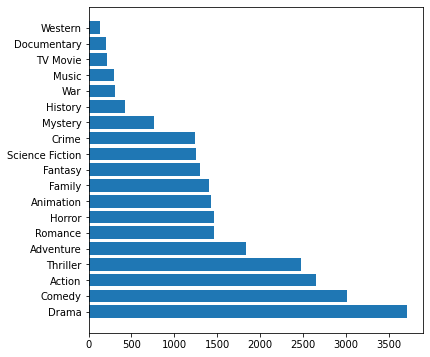

In [24]:
genres_data = genre_pipeline.transform(movies).sum().to_frame().sort_values(0, ascending=False).transpose()

plt.figure(figsize=(6,6))
plt.barh(y=genres_data.columns, width=genres_data.iloc[0])

plt.show()

Jak widać, najpopularniejszym gatunkiem (lub jednym z gatunków) dla filmów ze zbioru danych jest dramat (ok. 42% filmów), na drugim miejscu jest komedia (ok. 35% filmów) natomiast na trzecim filmy akcji (ok. 31% filmów).

Jeśli chodzi o najmniej popularne gatunki to western, film dokumentalny oraz film telewizyjny - każdy z nich występuje jedynie w ok. 1% filmów.

2. Ilość filmów w (oryginalnie) poszczególnych językach

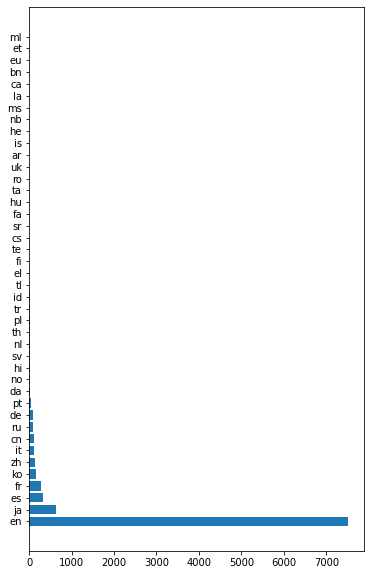

In [27]:
lang_data = pd.get_dummies(movies["Original_Language"]).sum().to_frame().sort_values(0, ascending=False).transpose()

plt.figure(figsize=(6,10))
plt.barh(lang_data.columns, lang_data.iloc[0])

plt.show()

Jak wynika z wykresu, przeważająca większość filmów w zbiorze danych jest oryginalnie w języku angielskim. Oznacza to, że ilość danych treningowych z innymi językami będzie stosunkowo mała, a co za tym idzie dowolny model będzie prawdopodobnie miał problemy z przewidywaniem w przypadku filmów z językiem oryginalnym innym niż angielski.

3. Średnie oceny filmów

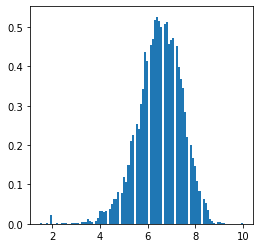

In [46]:
avg_votes = movies["Vote_Average"]

plt.figure(figsize=(4,4))
plt.hist(avg_votes, bins=100, density=True)

plt.show()

Rozkład średnich ocen, jak można się było spodziewać jest rozkładem normalnym o średniej ok. 7. Warto zauważyć, że o ile prawie nie ma filmów o średniej ocen równej 10, to dużo większa niż można by się tego było spodziewać liczba filmów ma średnią ocen nieco poniżej 2. Może to mieć znaczenie, jeśli chcielibyśmy używać przy uczeniu modelu metryk typu maksymalny błąd.

4. Rozkład długości tytułów filmów

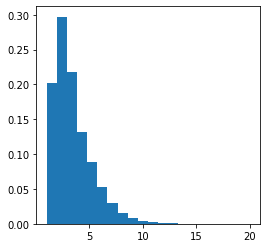

In [15]:
title_len = title_pipeline.transform(movies)["Title_Len"]

plt.figure(figsize=(4,4))
plt.hist(title_len, bins=20, density=True)

plt.show()

Długość tytułów filmów zdaje się być dana rozkładem Poissona. Większość filmów ma długość mniejszą, niż 5 słów, a co za tym idzie wytrenowane modele, będą miały potencjalnie problemy z filmami, których tytuły są długie (powyżej 7-8 słów).

5. Procent filmów zawierających cyfry / dwukropki / myślniki

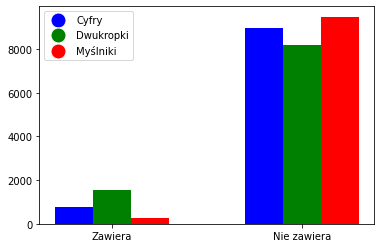

In [120]:
from matplotlib.lines import Line2D

titles_data = title_pipeline.transform(movies)

titles_has_numbers = titles_data["Title_Numbers"].sum()
titles_has_no_numbers = len(titles_data["Title_Numbers"]) - titles_has_numbers

titles_has_colon = titles_data["Title_Colon"].sum()
titles_has_no_colon = len(titles_data["Title_Colon"]) - titles_has_colon

titles_has_dash = titles_data["Title_Dash"].sum()
titles_has_no_dash = len(titles_data["Title_Dash"]) - titles_has_dash

labels = ["Zawiera", "Nie zawiera"]
x = np.arange(len(labels))

titles_numbers = [titles_has_numbers, titles_has_no_numbers]
titles_colons = [titles_has_colon, titles_has_no_colon]
titles_dashes = [titles_has_dash, titles_has_no_dash]

ax = plt.subplot(111)
ax.bar(x - 0.2, titles_numbers, width=0.2, color='b', align='center')
ax.bar(x, titles_colons, width=0.2, color='g', align='center', tick_label=labels)
ax.bar(x+0.2, titles_dashes, width=0.2, color='r', align='center')

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Cyfry', markerfacecolor='b', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Dwukropki', markerfacecolor='g', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Myślniki', markerfacecolor='r', markersize=15),
]
ax.legend(handles=custom_legend)

plt.show()

Jak widać większość tytułów filmów nie zawiera cyfr, dwukropków czy średników. Jest to o tyle istotna obserwacja, że często sequele filmów są odbierane gorzej niż film, po którym następuje

**MODELE**

In [122]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


1. ElasticNet

In [123]:
from sklearn.linear_model import ElasticNet

ElasticNet_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", ElasticNet())
])

ElasticNet_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

grid_1 = GridSearchCV(estimator=ElasticNet_pipeline,
                      param_grid=ElasticNet_param_grid, scoring="r2", cv=kFold)
grid_1.fit(X_train, y_train)
grid_1.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.250e+01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.191e-01, tolerance: 6.053e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'regressor__alpha': 0.001, 'scaler': None}

2. SVR RBF

In [136]:
from sklearn.svm import SVR

SVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", StandardScaler()),
    ("regressor", SVR(kernel="rbf"))
])

SVR_param_grid = {
    "regressor__C": [0.01, 0.1, 1, 10, 100, 1000],
    "regressor__gamma": [0.001, 0.01, 0.1, 1],
}

grid_2 = GridSearchCV(estimator=SVR_pipeline,
                      param_grid=SVR_param_grid, scoring="r2", cv=kFold)
grid_2.fit(X_train, y_train)
grid_2.best_params_


{'regressor__C': 1, 'regressor__gamma': 0.01}

3. Drzewo decyzyjne

In [137]:
from sklearn.tree import DecisionTreeRegressor

DecisionTree_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", DecisionTreeRegressor())
])

DecisionTree_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__max_depth": [None, 1, 2, 3, 4, 5],
    "regressor__max_features": [None, "auto", "sqrt", "log2"],
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
}

grid_3 = GridSearchCV(estimator=DecisionTree_pipeline,
                      param_grid=DecisionTree_param_grid, scoring="r2", cv=kFold)
grid_3.fit(X_train, y_train)
grid_3.best_params_


{'regressor__criterion': 'friedman_mse',
 'regressor__max_depth': 5,
 'regressor__max_features': None,
 'scaler': None}

4. Liniowy SVR

In [138]:
from sklearn.svm import LinearSVR

LinearSVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", LinearSVR())
])

LinearSVR_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

grid_4 = GridSearchCV(estimator=LinearSVR_pipeline,
                      param_grid=LinearSVR_param_grid, scoring="r2", cv=kFold)
grid_4.fit(X_train, y_train)
grid_4.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

{'regressor__C': 0.1, 'scaler': MinMaxScaler()}

5. Regresja Lasso

In [139]:
from sklearn.linear_model import Lasso

Lasso_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", Lasso())
])

Lasso_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
}

grid_5 = GridSearchCV(estimator=Lasso_pipeline,
                      param_grid=Lasso_param_grid, scoring="r2", cv=kFold)
grid_5.fit(X_train, y_train)
grid_5.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+02, tolerance: 6.025e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'regressor__alpha': 0.001, 'scaler': None}

**Porównanie płytkich modeli**

In [140]:
from sklearn.metrics import r2_score, mean_squared_error, max_error

models = []

models.append(("ElasticNet", grid_1.best_score_, grid_1.best_estimator_))
models.append(("SVR", grid_2.best_score_, grid_2.best_estimator_))
models.append(("Decision Tree", grid_3.best_score_, grid_3.best_estimator_))
models.append(("Linear SVR", grid_4.best_score_, grid_4.best_estimator_))
models.append(("Lasso", grid_5.best_score_, grid_5.best_estimator_))

names = []
scores_train = []
scores_test_r2 = []
scores_test_mse = []
scores_test_me = []

for name, train_score, estimator in models:
    names.append(name)
    scores_train.append(train_score)

    r2_test_score = r2_score(y_test, estimator.predict(X_test))
    scores_test_r2.append(r2_test_score)

    mse_test_score = mean_squared_error(y_test, estimator.predict(X_test))
    scores_test_mse.append(mse_test_score)

    me_test_score = max_error(y_test, estimator.predict(X_test))
    scores_test_me.append(me_test_score)


model_data = {
    "model name": names,
    "training score (r2)": scores_train,
    "test score (r2)": scores_test_r2,
    "test score (mean squared error)": scores_test_mse,
    "test score (max error)": scores_test_me
}
table = pd.DataFrame(model_data)
table


,model name,training score (r2),test score (r2),test score (mean squared error),test score (max error)
0,ElasticNet,0.197765,0.206277,0.659564,4.374806
1,SVR,0.229291,0.245390,0.627062,4.841273
2,Decision Tree,0.177975,0.174545,0.685932,4.215801
3,Linear SVR,0.190060,0.197382,0.666955,4.429653
4,Lasso,0.197216,0.204051,0.661413,4.374988


Prawdziwy rozkład


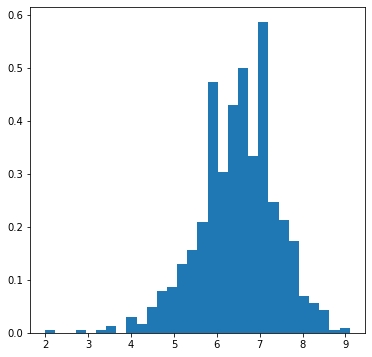

model: ElasticNet


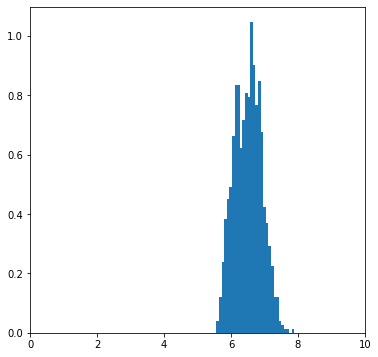

model: SVR


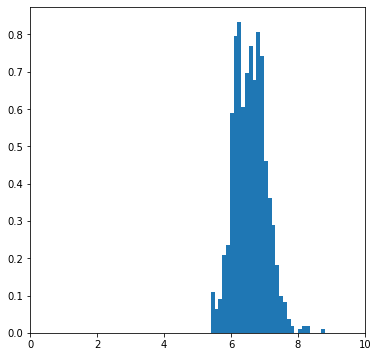

model: Decision Tree


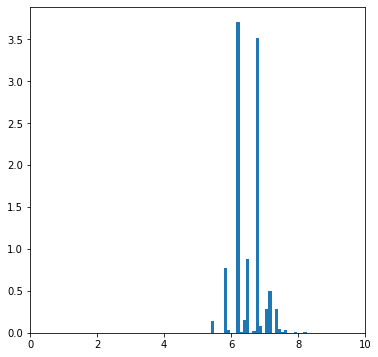

model: Linear SVR


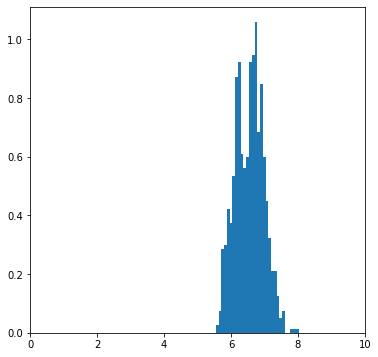

model: Lasso


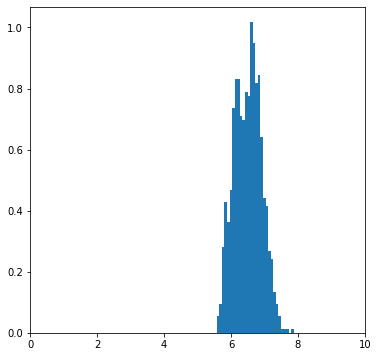

In [143]:
plt.figure(figsize=(6,6))
print(f"Prawdziwy rozkład")
plt.hist(y_test, bins=30, density=True)
plt.show()

for name, _, estimator in models:
    print(f"model: {name}")
    plt.figure(figsize=(6,6))
    plt.xlim((0,10))
    plt.hist(estimator.predict(X_test), bins=30, density=True)
    plt.show()


Jak widać, wszystkie modele płytkie (poza drzewem decyzyjnym) przewidują oceny o rozkładzie (w przybliżeniu) normalnym. Rozkład ten ma średnią zbliżoną do średniej z prawdziwych wyników, ale zdecydowanie mniejsze odchylenie standardowe.

Najlepszy pod kątem wyniku r^2 model, którym jest SVR z jądrem RBF, ma rozkład najbardziej zbliżony do danych prawdziwych (w szczególności warto zwrócić uwagę na większą częstość wyników ok. wartości 6 i 7, która jest wynikiem losowego wybrania danych testowych).

**Modele głębokie**

In [144]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [145]:
X_train_preprocessed = preprocess_pipeline.transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_preprocessed)

X_train_keras = scaler.transform(X_train_preprocessed)
X_test_keras = scaler.transform(X_test_preprocessed)

print(X_train_keras.shape)
print(X_test_keras.shape)


(8754, 66)
(973, 66)


In [146]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

from keras.callbacks import History

In [147]:
from sklearn.model_selection import RandomizedSearchCV

In [148]:
from keras import backend as K


def keras_r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [149]:
from keras.callbacks import EarlyStopping
early_stopping_grid_search = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [150]:
def build_model(n_hidden=1, n_neurons=30, activation="relu", dropout=None, batch_normalization=False, learning_rate=3e-3, input_shape=[66,]):
    model = keras.models.Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        if dropout or batch_normalization:
          model.add(keras.layers.Dense(n_neurons))
        else:
          model.add(keras.layers.Dense(n_neurons, use_bias=False))
        
        if batch_normalization:
          model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Activation(activation))

        if dropout:
          model.add(keras.layers.Dropout(dropout))

    
    model.add(keras.layers.Dense(1, activation="relu"))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[keras_r2])

    return model

In [151]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

C:\Users\Admin\AppData\Local\Temp\ipykernel_8548\3463659828.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


1. Karas Randomized Search CV (liczba warstw + liczba neuronów)

In [ ]:
param_distribs_1 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
}

rnd_search_cv_1 = RandomizedSearchCV(keras_class, param_distribs_1, n_iter=30, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_1.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_1.best_params_

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
176/176 [==============================] - 0s 2ms/step - loss: 72.5646 - keras_r2: 0.1158 - val_loss: 125.8454 - val_keras_r2: -0.5337
Epoch 19/100
176/176 [==============================] - 0s 2ms/step - loss: 73.1342 - keras_r2: 0.0494 - val_loss: 112.8989 - val_keras_r2: -0.4047
Epoch 20/100
176/176 [==============================] - 0s 2ms/step - loss: 73.2118 - keras_r2: 0.1115 - val_loss: 78.1986 - val_keras_r2: 0.0730
Epoch 21/100
176/176 [==============================] - 0s 2ms/step - loss: 72.3083 - keras_r2: 0.0812 - val_loss: 77.5881 - val_keras_r2: 0.0905
Epoch 22/100
176/176 [==============================] - 0s 2ms/step - loss: 72.8234 - keras_r2: -0.0014 - val_loss: 76.2159 - val_keras_r2: 0.1047
Epoch 23/100
176/176 [==============================] - 0s 2ms/step - loss: 72.4278 - keras_r2: 0.1138 - val_loss: 86.3537 - val_keras_r2: -0.0222
Epoch 24/100
176/176 [==============================] - 0s 2ms/ste

{'n_hidden': 3, 'n_neurons': 22}

In [190]:
history = History()

model_1 = Sequential()
model_1.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(1,activation="relu"))
model_1.summary()

model_1.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 22)                1474      
                                                                 
 dense_9 (Dense)             (None, 22)                506       
                                                                 
 dense_10 (Dense)            (None, 22)                506       
                                                                 
 dense_11 (Dense)            (None, 1)                 23        
                                                                 
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________


In [191]:
history_1 = model_1.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
])

Epoch 1/100
274/274 [==============================] - 1s 3ms/step - loss: 2.9519 - keras_r2: -2.7243 - val_loss: 0.8250 - val_keras_r2: -0.0124
Epoch 2/100
274/274 [==============================] - 1s 3ms/step - loss: 0.7286 - keras_r2: 0.1345 - val_loss: 0.6720 - val_keras_r2: 0.1686
Epoch 3/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6948 - keras_r2: 0.1611 - val_loss: 0.6628 - val_keras_r2: 0.1749
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6785 - keras_r2: 0.1827 - val_loss: 0.6480 - val_keras_r2: 0.2007
Epoch 5/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6647 - keras_r2: 0.1991 - val_loss: 0.6341 - val_keras_r2: 0.2187
Epoch 6/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6600 - keras_r2: 0.2045 - val_loss: 0.6332 - val_keras_r2: 0.2119
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6511 - keras_r2: 0.2167 - val_loss: 0.6447 - val_keras_r2: 0.19

In [192]:
model_1.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.6269 - keras_r2: 0.2079


[0.6268920302391052, 0.20787283778190613]

In [ ]:
history_1.history.keys()

dict_keys(['loss', 'keras_r2', 'val_loss', 'val_keras_r2'])

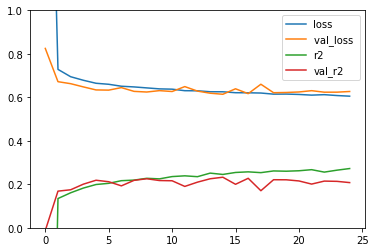

In [193]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_1.history['loss'], label="loss")
plt.plot(history_1.history['val_loss'], label="val_loss ")

plt.plot(history_1.history['keras_r2'], label="r2")
plt.plot(history_1.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

Jako, że parametry tej sieci neuronowej (liczba warstw ukrytych i ilość neuronów na warstwę) były wybrane za pomocą `randomized search`, mimo wielokrotnego losowania i uczenia modelu dla wielu kombinacji wybranych jako najlepsze, model ten jest dosyć słaby.

Potencjalnymi czynnikami, które również wpływają na jakość modelu są taka sama ilość neuronów w każdej warstwie ukrytej (co jest wymuszone przez sposób losowego przeszukiwania hiperparametrów) oraz brak poszukiwania odpowiedniej funkcji aktywacji, ew. normalizacji batchy oraz dropoutów.

2. Karas Randomized Search CV (liczba warstw + liczba neuronów + funkcja aktywacji)

In [ ]:
param_distribs_2 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
    "activation": ["relu", "elu", "sigmoid", "tanh"],
}

rnd_search_cv_2 = RandomizedSearchCV(keras_class, param_distribs_2, n_iter=10, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_2.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_2.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
176/176 [==============================] - 1s 3ms/step - loss: 1933.4823 - keras_r2: -34.5009 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.1635 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.6227 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -28.3675 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -24.7708 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.0529 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 7/100
176/176 [

{'activation': 'elu', 'n_hidden': 4, 'n_neurons': 23}

In [194]:
history_2 = History()

model_2 = Sequential()
model_2.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(1,activation="relu"))
model_2.summary()

model_2.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 23)                1541      
                                                                 
 dense_13 (Dense)            (None, 23)                552       
                                                                 
 dense_14 (Dense)            (None, 23)                552       
                                                                 
 dense_15 (Dense)            (None, 23)                552       
                                                                 
 dense_16 (Dense)            (None, 1)                 24        
                                                                 
Total params: 3,221
Trainable params: 3,221
Non-trainable params: 0
_________________________________________________________________


In [195]:
history_2 = model_2.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

Epoch 1/100
274/274 [==============================] - 2s 3ms/step - loss: 1.4817 - keras_r2: -0.7015 - val_loss: 0.7808 - val_keras_r2: 0.0239
Epoch 2/100
274/274 [==============================] - 1s 3ms/step - loss: 0.7185 - keras_r2: 0.1299 - val_loss: 0.6704 - val_keras_r2: 0.1763
Epoch 3/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6993 - keras_r2: 0.1591 - val_loss: 0.6617 - val_keras_r2: 0.1839
Epoch 4/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6946 - keras_r2: 0.1638 - val_loss: 0.6606 - val_keras_r2: 0.1853
Epoch 5/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6857 - keras_r2: 0.1774 - val_loss: 0.6734 - val_keras_r2: 0.1703
Epoch 6/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6807 - keras_r2: 0.1803 - val_loss: 0.6540 - val_keras_r2: 0.1837
Epoch 7/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6766 - keras_r2: 0.1811 - val_loss: 0.6396 - val_keras_r2: 0.211

In [196]:
model_2.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.6117 - keras_r2: 0.2351


[0.6116870045661926, 0.2351062148809433]

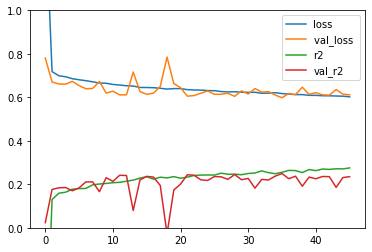

In [197]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_2.history['loss'], label="loss")
plt.plot(history_2.history['val_loss'], label="val_loss ")

plt.plot(history_2.history['keras_r2'], label="r2")
plt.plot(history_2.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

Podobnie jak w poprzednim modelu parametry zostały dobrane za pomocą `randomized search`, a więc nie ma mimo wielokrotnego przeszukiwania gwarancji, że są one optymalne.

Jako, że w odróżnieniu od modelu poprzedniego dla tego modelu testowane są również różne funkcje aktywacji, model jest nieco lepszy, ale nie daje to (przynajmniej dla hiperparametrów wybranych w `randomized search`) zbyt dużego wpływu na ostateczny wynik.

3. Karas Randomized Search CV (liczba warstw + liczba neuronów + funkcja aktywacji + normalizacja + dropout)



In [ ]:
param_distribs_3 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
    "activation": ["relu", "elu", "sigmoid", "tanh"],
    "dropout": [0.1, 0.2, 0.3],
    "batch_normalization": [True, False],
}

rnd_search_cv_3 = RandomizedSearchCV(keras_class, param_distribs_3, n_iter=10, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_3.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_3.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
176/176 [==============================] - 3s 6ms/step - loss: 237.2287 - keras_r2: -4.2866 - val_loss: 76.7985 - val_keras_r2: 0.0996
Epoch 2/100
176/176 [==============================] - 1s 5ms/step - loss: 125.2039 - keras_r2: -0.6041 - val_loss: 79.5292 - val_keras_r2: 0.0684
Epoch 3/100
176/176 [==============================] - 1s 4ms/step - loss: 113.9511 - keras_r2: -0.6522 - val_loss: 74.5797 - val_keras_r2: 0.1288
Epoch 4/100
176/176 [==============================] - 1s 4ms/step - loss: 109.3372 - keras_r2: -0.4478 - val_loss: 74.7149 - val_keras_r2: 0.1252
Epoch 5/100
176/176 [==============================] - 1s 5ms/step - loss: 104.2877 - keras_r2: -0.4131 - val_loss: 81.2418 - val_keras_r2: 0.0253
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 97.8899 - keras_r2: -0.2290 - val_loss: 77.3570 - val_keras_r2: 0.0796
Epoch 7/100
176/176 [==============================] - 1s 

{'activation': 'elu',
 'batch_normalization': True,
 'dropout': 0.2,
 'n_hidden': 2,
 'n_neurons': 9}

In [198]:
history_3 = History()

model_3 = Sequential()
model_3.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_3.add(Dense(9, use_bias=False))
model_3.add(BatchNormalization())
model_3.add(Activation("elu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(9, use_bias=False))
model_3.add(BatchNormalization())
model_3.add(Activation("elu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(1,activation="relu"))
model_3.summary()

model_3.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 9)                 594       
                                                                 
 batch_normalization (BatchN  (None, 9)                36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 9)                 0         
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 dense_18 (Dense)            (None, 9)                 81        
                                                                 
 batch_normalization_1 (Batc  (None, 9)                36        
 hNormalization)                                      

In [199]:
# history_3 = model_3.fit(X_train_keras, y_train, validation_data=(
#     X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])
history_3 = model_3.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=1000)

Epoch 1/1000
274/274 [==============================] - 2s 5ms/step - loss: 3.7505 - keras_r2: -3.7145 - val_loss: 0.8118 - val_keras_r2: -0.0299
Epoch 2/1000
274/274 [==============================] - 1s 4ms/step - loss: 1.3798 - keras_r2: -0.7553 - val_loss: 0.7498 - val_keras_r2: 0.0612
Epoch 3/1000
274/274 [==============================] - 1s 4ms/step - loss: 1.1060 - keras_r2: -0.3776 - val_loss: 0.7223 - val_keras_r2: 0.1040
Epoch 4/1000
274/274 [==============================] - 1s 4ms/step - loss: 0.9884 - keras_r2: -0.2214 - val_loss: 0.7375 - val_keras_r2: 0.0714
Epoch 5/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.9135 - keras_r2: -0.1128 - val_loss: 0.7071 - val_keras_r2: 0.1278
Epoch 6/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.8562 - keras_r2: -0.0402 - val_loss: 0.7001 - val_keras_r2: 0.1360
Epoch 7/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.8217 - keras_r2: -0.0027 - val_loss: 0.7031 - val_k

In [200]:
model_3.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.6090 - keras_r2: 0.2447


[0.6090407967567444, 0.2447379231452942]

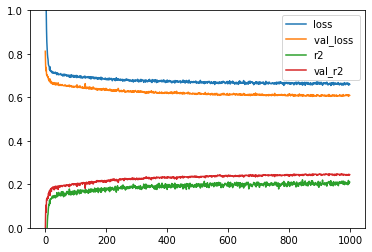

In [201]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_3.history['loss'], label="loss")
plt.plot(history_3.history['val_loss'], label="val_loss ")

plt.plot(history_3.history['keras_r2'], label="r2")
plt.plot(history_3.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

Podobnie jak w przypadku 2 poprzednich modeli, hiperparametry tutaj wyznaczone zostały w sposób losowy, jednak tym razem brana pod uwagę była ewentualna normalizacja batchy oraz dropout.

Efekt tego jest zauważalny, gdyż o ile poprzednie modele głębokie musiały mieć dodany `early stopping`, ponieważ ostatecznie traciły dokładność, tutaj jest to nie wymagane. Jak widać na wykresie histori, zarówno dla treningu i walidacji `r^2` rosło, matomiast `loss` malało. Dla walidacji, krzywe te dosyć mocno oscylują, natomiast widać ogólny trend.

4. Parametry dobrane ręcznie

In [211]:
history_4 = History()

model_4 = Sequential()
model_4.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_4.add(Dense(100, use_bias=False))
model_4.add(BatchNormalization())
model_4.add(Activation("elu"))
model_4.add(Dropout(0.15))
model_4.add(Dense(50, use_bias=False))
model_4.add(BatchNormalization())
model_4.add(Activation("elu"))
model_4.add(Dropout(0.15))
model_4.add(Dense(10, use_bias=False))
model_4.add(BatchNormalization())
model_4.add(Activation("elu"))
model_4.add(Dropout(0.15))
model_4.add(Dense(1,activation="relu"))
model_4.summary()

model_4.compile(loss="mean_squared_error",optimizer="Adam", metrics=[keras_r2])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               6600      
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 50)                5000      
                                                                 
 batch_normalization_9 (Batc  (None, 50)               200       
 hNormalization)                                      

In [212]:
# history_4 = model_4.fit(X_train_keras, y_train, validation_data=(
#     X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])
history_4 = model_4.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=300)

Epoch 1/300
274/274 [==============================] - 3s 5ms/step - loss: 23.6071 - keras_r2: -29.7619 - val_loss: 13.8857 - val_keras_r2: -19.0824
Epoch 2/300
274/274 [==============================] - 1s 4ms/step - loss: 13.0018 - keras_r2: -15.9998 - val_loss: 8.9519 - val_keras_r2: -11.8363
Epoch 3/300
274/274 [==============================] - 1s 4ms/step - loss: 10.7720 - keras_r2: -13.1529 - val_loss: 8.0984 - val_keras_r2: -10.4803
Epoch 4/300
274/274 [==============================] - 1s 5ms/step - loss: 9.6061 - keras_r2: -11.6920 - val_loss: 4.8462 - val_keras_r2: -5.6993
Epoch 5/300
274/274 [==============================] - 1s 4ms/step - loss: 5.9800 - keras_r2: -6.8274 - val_loss: 3.9574 - val_keras_r2: -4.2544
Epoch 6/300
274/274 [==============================] - 1s 4ms/step - loss: 5.4821 - keras_r2: -6.2498 - val_loss: 3.8588 - val_keras_r2: -4.1214
Epoch 7/300
274/274 [==============================] - 1s 4ms/step - loss: 5.1273 - keras_r2: -5.7711 - val_loss: 3.840

In [213]:
model_4.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.5869 - keras_r2: 0.2543


[0.5868998765945435, 0.25427451729774475]

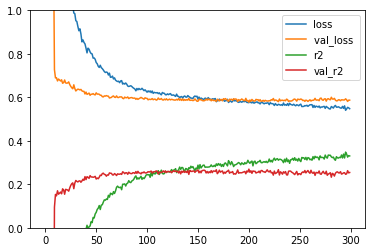

In [214]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_4.history['loss'], label="loss")
plt.plot(history_4.history['val_loss'], label="val_loss ")

plt.plot(history_4.history['keras_r2'], label="r2")
plt.plot(history_4.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

W odróżnieniu od pozostałych modeli głębokich, dane tutaj zostały dobrane ręcznie. Oznacza to, że nie było ograniczenia co do tego, że w każdej warstwie ukrytej musi być tyle samo neuronów.

Podobnie jak w przypadku poprzedniego modelu krzywe oscylują (jest to bardziej wyraźne, ze względu na mniejszą ilość epok), ale dalej da się zauważyć trend (przedewszystkim przy treningu, ale również przy walidacji) gdzie `r^2` rośnie, podczas gdy `loss` maleje.

**Porównanie modeli głębokich**

In [215]:
from sklearn.metrics import r2_score, mean_squared_error, max_error

models = []

models.append(("Podstawowa (wczesne zatrzymanie)", model_1))
models.append(("Podstawowa z dobraną funkcją aktywacji (wczesne zatrzymanie)", model_2))
models.append(("Z Batch Normalization i Dropout (1000 epok)", model_3))
models.append(("Dobrane ręcznie parametry (300 epok)", model_4))

names = []
scores_test_r2 = []
scores_test_mse = []
scores_test_me = []

for name, estimator in models:
    names.append(name)

    r2_test_score = r2_score(y_test, estimator.predict(X_test_keras))
    scores_test_r2.append(r2_test_score)

    mse_test_score = mean_squared_error(y_test, estimator.predict(X_test_keras))
    scores_test_mse.append(mse_test_score)

    me_test_score = max_error(y_test, estimator.predict(X_test_keras))
    scores_test_me.append(me_test_score)


model_data = {
    "model name": names,
    "test score (r2)": scores_test_r2,
    "test score (mean squared error)": scores_test_mse,
    "test score (max error)": scores_test_me
}
table = pd.DataFrame(model_data)
table


,model name,test score (r2),test score (mean squared error),test score (max error)
0,Podstawowa (wczesne zatrzymanie),0.245594,0.626892,4.577204
1,Podstawowa z dobraną funkcją aktywacji (wczesn...,0.263892,0.611687,4.182799
2,Z Batch Normalization i Dropout (1000 epok),0.267076,0.609041,4.237071
3,Dobrane ręcznie parametry (300 epok),0.293721,0.586900,3.259960


Prawdziwy rozkład


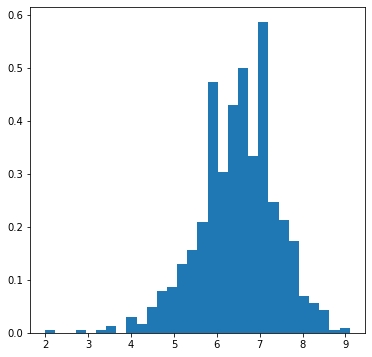

model: Podstawowa (wczesne zatrzymanie)


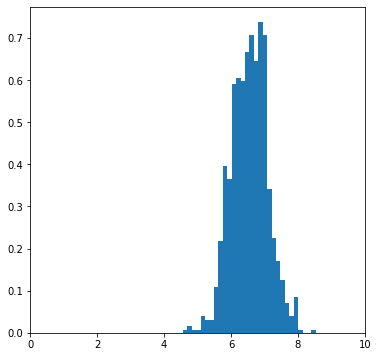

model: Podstawowa z dobraną funkcją aktywacji (wczesne zatrzymanie)


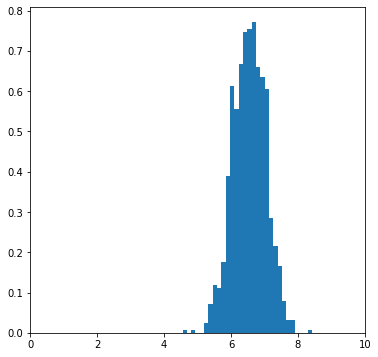

model: Z Batch Normalization i Dropout (1000 epok)


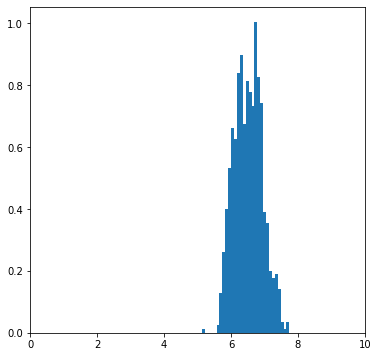

model: Dobrane ręcznie parametry (300 epok)


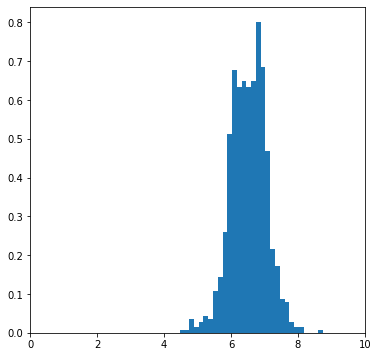

In [217]:
plt.figure(figsize=(6,6))
print(f"Prawdziwy rozkład")
plt.hist(y_test, bins=30, density=True)
plt.show()

for name, estimator in models:
    print(f"model: {name}")
    plt.figure(figsize=(6,6))
    plt.xlim((0,10))
    plt.hist(estimator.predict(X_test_keras), bins=30, density=True)
    plt.show()


Podobnie jak w przypadku modeli płytkich, modele głębokie przewidują rozkład normalny ocen, natomiast jest on bardziej zbliżony do rozkładu prawdziwego. W szczególności w modelu, z dobranymi ręcznie parametrami można zauważyć wyraźnie więcej punktów o wartości 6 i 7, co pokrywa się z rozkładem prawdziwych wyników i wynika z losowego podziału na zbiór treningowy i testowy.

# Podsumowanie